In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system','9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.001
training_iters = 8000000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    print(fc1.shape)
    
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    fc2 = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    print(fc2.shape)
    return fc2

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # fully connected, 3*4*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([3*4*64, 1024])),
    # 1024 inputs, 14 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [7]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 64)
(?, 1024)
(?, 14)


# train and test

In [8]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 29444.914062, Accuracy = 0.0899999961257
Performance on test set: Training epochs #1000, Batch Loss = 14989.3603516, Accuracy = 0.183999985456
Training epochs #20000: Batch Loss = 6437.780273, Accuracy = 0.291999995708
Performance on test set: Training epochs #20000, Batch Loss = 13005.1855469, Accuracy = 0.0100000007078
Training epochs #40000: Batch Loss = 1707.780029, Accuracy = 0.838000059128
Performance on test set: Training epochs #40000, Batch Loss = 1456.81396484, Accuracy = 0.805000066757
Training epochs #60000: Batch Loss = 1107.353638, Accuracy = 0.883000016212
Performance on test set: Training epochs #60000, Batch Loss = 818.282409668, Accuracy = 0.93900001049
Training epochs #80000: Batch Loss = 637.999573, Accuracy = 0.916000068188
Performance on test set: Training epochs #80000, Batch Loss = 615.12322998, Accuracy = 0.943000018597
Training epochs #100000: Batch Loss = 4244.128418, Accuracy = 0.288000017405
Performance on test set: Train

Training epochs #920000: Batch Loss = 39.734940, Accuracy = 0.944000065327
Performance on test set: Training epochs #920000, Batch Loss = 36.5505867004, Accuracy = 0.961000025272
Training epochs #940000: Batch Loss = 76.629837, Accuracy = 0.957000076771
Performance on test set: Training epochs #940000, Batch Loss = 44.1397628784, Accuracy = 0.961000025272
Training epochs #960000: Batch Loss = 34.025867, Accuracy = 0.956000030041
Performance on test set: Training epochs #960000, Batch Loss = 32.2094802856, Accuracy = 0.961000025272
Training epochs #980000: Batch Loss = 552.178284, Accuracy = 0.560000002384
Performance on test set: Training epochs #980000, Batch Loss = 24.048915863, Accuracy = 0.841000020504
Training epochs #1000000: Batch Loss = 41.511375, Accuracy = 0.947999954224
Performance on test set: Training epochs #1000000, Batch Loss = 29.5014152527, Accuracy = 0.961000084877
Training epochs #1020000: Batch Loss = 53.107422, Accuracy = 0.955000042915
Performance on test set: Tr

Training epochs #1840000: Batch Loss = 4.333424, Accuracy = 0.986000061035
Performance on test set: Training epochs #1840000, Batch Loss = 1.08076119423, Accuracy = 0.993000030518
Training epochs #1860000: Batch Loss = 220.435181, Accuracy = 0.695000052452
Performance on test set: Training epochs #1860000, Batch Loss = 9.2069978714, Accuracy = 0.976000010967
Training epochs #1880000: Batch Loss = 13.411846, Accuracy = 0.975000083447
Performance on test set: Training epochs #1880000, Batch Loss = 10.3281793594, Accuracy = 0.963000059128
Training epochs #1900000: Batch Loss = 17.979399, Accuracy = 0.980000019073
Performance on test set: Training epochs #1900000, Batch Loss = 3.25840091705, Accuracy = 0.985000014305
Training epochs #1920000: Batch Loss = 4.997252, Accuracy = 0.983000040054
Performance on test set: Training epochs #1920000, Batch Loss = 0.757252931595, Accuracy = 0.993000030518
Training epochs #1940000: Batch Loss = 164.819305, Accuracy = 0.739000022411
Performance on test

Training epochs #2760000: Batch Loss = 0.937434, Accuracy = 0.994000017643
Performance on test set: Training epochs #2760000, Batch Loss = 0.248357266188, Accuracy = 0.993000030518
Training epochs #2780000: Batch Loss = 3.572149, Accuracy = 0.991000056267
Performance on test set: Training epochs #2780000, Batch Loss = 0.0249818135053, Accuracy = 0.999000072479
Training epochs #2800000: Batch Loss = 1.014999, Accuracy = 0.994000077248
Performance on test set: Training epochs #2800000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #2820000: Batch Loss = 76.617821, Accuracy = 0.768000006676
Performance on test set: Training epochs #2820000, Batch Loss = 0.964051902294, Accuracy = 0.984000086784
Training epochs #2840000: Batch Loss = 0.794668, Accuracy = 0.991999983788
Performance on test set: Training epochs #2840000, Batch Loss = 0.040583498776, Accuracy = 0.999000072479
Training epochs #2860000: Batch Loss = 3.194098, Accuracy = 0.987000048161
Performance on test set: Train

Training epochs #3720000: Batch Loss = 1.009529, Accuracy = 0.991999983788
Performance on test set: Training epochs #3720000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #3740000: Batch Loss = 1.983664, Accuracy = 0.990000069141
Performance on test set: Training epochs #3740000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #3760000: Batch Loss = 0.199380, Accuracy = 0.999000072479
Performance on test set: Training epochs #3760000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #3780000: Batch Loss = 22.591351, Accuracy = 0.871999979019
Performance on test set: Training epochs #3780000, Batch Loss = 0.230116844177, Accuracy = 0.997000098228
Training epochs #3800000: Batch Loss = 0.473317, Accuracy = 0.993999958038
Performance on test set: Training epochs #3800000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #3820000: Batch Loss = 0.516693, Accuracy = 0.996000051498
Performance on test set: Training epochs #3820000, Batch Loss = 0.0

Training epochs #4680000: Batch Loss = 0.116714, Accuracy = 0.995000123978
Performance on test set: Training epochs #4680000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #4700000: Batch Loss = 0.444528, Accuracy = 0.994000077248
Performance on test set: Training epochs #4700000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #4720000: Batch Loss = 0.068215, Accuracy = 0.999000132084
Performance on test set: Training epochs #4720000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #4740000: Batch Loss = 5.336831, Accuracy = 0.925999999046
Performance on test set: Training epochs #4740000, Batch Loss = 0.000472610001452, Accuracy = 1.00000011921
Training epochs #4760000: Batch Loss = 0.184277, Accuracy = 0.995000064373
Performance on test set: Training epochs #4760000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #4780000: Batch Loss = 0.082964, Accuracy = 0.998000025749
Performance on test set: Training epochs #4780000, Batch Loss = 0.0, Accuracy = 1.00000011921
Tr

Training epochs #5660000: Batch Loss = 0.192045, Accuracy = 0.998000025749
Performance on test set: Training epochs #5660000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #5680000: Batch Loss = 0.015506, Accuracy = 0.999000072479
Performance on test set: Training epochs #5680000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #5700000: Batch Loss = 1.820007, Accuracy = 0.960000157356
Performance on test set: Training epochs #5700000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #5720000: Batch Loss = 0.044130, Accuracy = 0.998000085354
Performance on test set: Training epochs #5720000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #5740000: Batch Loss = 0.004764, Accuracy = 0.999000072479
Performance on test set: Training epochs #5740000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #5760000: Batch Loss = 0.018373, Accuracy = 0.999000072479
Performance on test set: Training epochs #5760000, Batch Loss = 0.0, Accuracy = 

Training epochs #6640000: Batch Loss = 0.019985, Accuracy = 0.998000085354
Performance on test set: Training epochs #6640000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6660000: Batch Loss = 5.045878, Accuracy = 0.941000044346
Performance on test set: Training epochs #6660000, Batch Loss = 25.5268363953, Accuracy = 0.865999996662
Training epochs #6680000: Batch Loss = 1.378714, Accuracy = 0.989000082016
Performance on test set: Training epochs #6680000, Batch Loss = 7.4927406311, Accuracy = 0.981000065804
Training epochs #6700000: Batch Loss = 1.176916, Accuracy = 0.991000056267
Performance on test set: Training epochs #6700000, Batch Loss = 3.86236855832e-08, Accuracy = 1.00000011921
Training epochs #6720000: Batch Loss = 0.009571, Accuracy = 0.999000072479
Performance on test set: Training epochs #6720000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6740000: Batch Loss = 5.784435, Accuracy = 0.902000069618
Performance on test set: Training epochs #674

Training epochs #7580000: Batch Loss = 0.511666, Accuracy = 0.996000051498
Performance on test set: Training epochs #7580000, Batch Loss = 7.86780329776e-09, Accuracy = 1.00000011921
Training epochs #7600000: Batch Loss = 0.074621, Accuracy = 0.998000085354
Performance on test set: Training epochs #7600000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7620000: Batch Loss = 2.575561, Accuracy = 0.93599998951
Performance on test set: Training epochs #7620000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7640000: Batch Loss = 0.313144, Accuracy = 0.987000048161
Performance on test set: Training epochs #7640000, Batch Loss = 0.0205501001328, Accuracy = 0.996999979019
Training epochs #7660000: Batch Loss = 0.352531, Accuracy = 0.991999983788
Performance on test set: Training epochs #7660000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7680000: Batch Loss = 0.034701, Accuracy = 0.997000098228
Performance on test set: Training epochs #7680000, Bat

# performance visualization

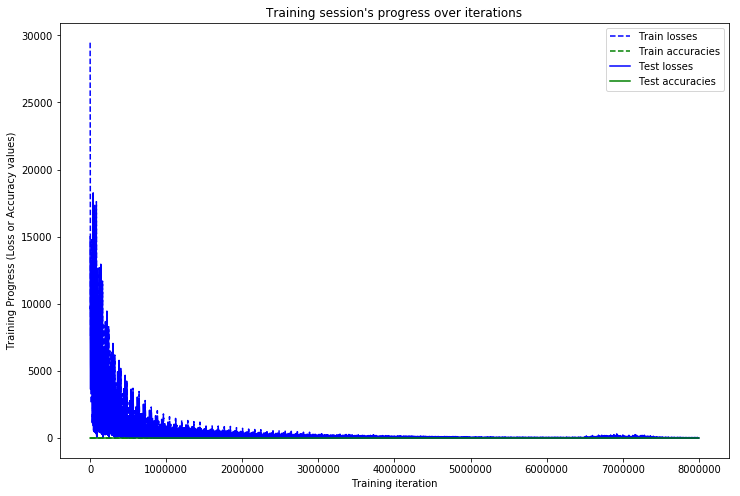

In [9]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 100.000011921%

Precision: 96.9475600227%
Recall: 96.87%
f1_score: 96.7746981493%

Confusion Matrix:
[[    0    18     0     0     0     0     0     0     0     0     0     0
      0]
 [    0   803    18     0    27    22    16    11     5     0     0     9
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0]
 [    0   114     0     0  2763     0     0    11     0     0     0     3
      0]
 [    0    57     0     0     2   280     1     7     0     0     0     1
      0]
 [    0     7     2     0     0     0 14486     0     0     0     0     0
      0]
 [    0    76     6     0    34    30    31   336    11     0     0    11
      0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0]
 [    0     0     2     0     0     0     0     0     0     2     0     0
      0]
 [    0     0     0     0     0     0     0   

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


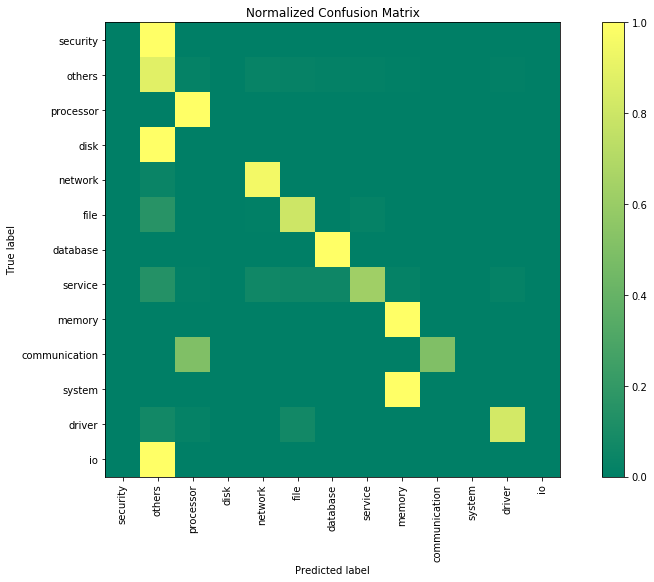

In [10]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)